In [1]:
from scipy.io import wavfile
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift, ifft
from numpy import linalg as LA
from scipy.io.wavfile import write
import winsound
import wavio
from playsound import playsound

# Punto 3

### A continuación se presentan las funciones necesarias para correr este script. 

La primera permite crear un filtro pasa banda entre las frecuencias $Fc1$ y $Fc2$ usando un filtro FIR de orden $N$.

La segunda permite crear un filtro pasabajas con frecuencia de corte $Fc1$ usando un filtro FIR de orden $N$.

La tercera permite filtrar una señal de entrada $entrada$ con un filtro $filtro$, produciendo una salida $filtrada$, usando un filtro FIR de orden $N$.

La cuarta permite crear una onda coseno de frecuencia $freq$, a una frecuencia de muestreo $sample$_$rate$ y una duración $duration$.

In [2]:
def crear_bandpass(N, Fc1, Fc2):
    
    def h1(k):
        if k == N/2:
            return (Fc1/np.pi)
        elif k <= N and k >= 0:
            return (np.sin(Fc1*(k-N/2)))/(np.pi*(k-N/2))
        else:
            return 0

    def h2(k):
        if k == N/2:
            return (Fc2/np.pi)
        elif k <= N and k >= 0:
            return (np.sin(Fc2*(k-N/2)))/(np.pi*(k-N/2))
        else:
            return 0
    
    hk1 = []
    hk2 = []

    for i in range(0, N):
        hk1.append(h1(i))
        hk2.append(h2(i))

    # hk = hk1 - hk2

    hk = np.subtract(hk1, hk2)
    
    return hk

def crear_LP(N, Fc1):
    
    def h1(k):
        if k == N/2:
            return (Fc1/np.pi)
        elif k <= N and k >= 0:
            return (np.sin(Fc1*(k-N/2)))/(np.pi*(k-N/2))
        else:
            return 0
    
    hk1 = []

    for i in range(0, N):
        hk1.append(h1(i))
    
    return hk1


def filtrar_señal(N, filtro, entrada):
    
    def w(n):
        if n >= 0 and n <= N:
            return 1
        else:
            return 0

    def b(k):
        return filtro[k]*w(k)

    def y(n, x):
        y = 0
        for k in range(0, N):
            y = y + b(k)*x[n-k]

        return y

    filtrada = []

    for n in range(len(entrada)):
        f = y(n,entrada)
        filtrada.append(f)
        
    return filtrada

def generate_cos_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.cos takes radians
    y = np.cos((2 * np.pi) * frequencies)
    return x, y

Se presenta la señal codificada en el dominio del tiempo con su respectiva transformada de Fourier.

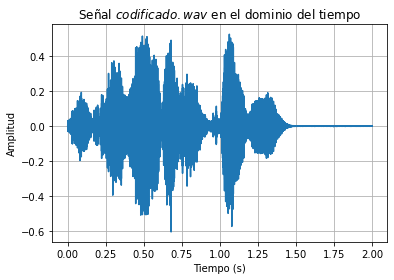

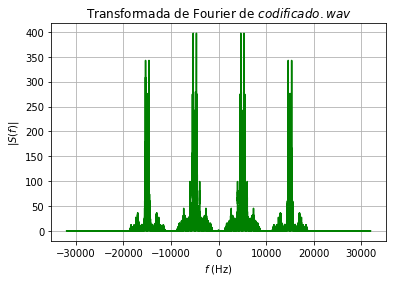

In [3]:
samprate3, s3 = wavfile.read('codificado.wav')

s3 = s3/32767 # El formato de s es de un número entero de 16 bits, que tiene un rango entre -32768 a 32767.

length3 = s3.shape[0]/samprate3 # Duración en segundos
duration = int(length3) # Duración en segundos enteros

t = np.linspace(0, length3, s3.shape[0]) 

plt.plot(t, s3)
plt.grid()
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title("Señal $codificado.wav$ en el dominio del tiempo")

fouriers = fft(s3)
f3 = fftfreq(s3.shape[0], 1/samprate3) # Window length: s.shape[0], Sample spacing: 1/samprate1 

plt.figure()

plt.plot(f3, np.abs(fouriers), color='g')
plt.grid()
plt.xlabel('$f$ (Hz)')
plt.ylabel('|$S(f)$|')
plt.title("Transformada de Fourier de $codificado.wav$")

playsound('codificado.wav')

Se puede notar que existen dos frecuencias muy importantes: $5kHz$ y $15kHz$. La idea es crear dos filtros: uno para quedarse solo con la frecuencia de $5kHz$ que puede ser un pasabajas con frecuencia de corte en $10kHz$, y otro para quedarse solo con la frecuencia de $15kHz$, que puede ser un pasabanda entre $10kHz$ y $20kHz$. Alternativamente se podría usar un pasa altas con frecuencia de corte de $10kHz$. 

En este caso, se usó un pasabajas y un pasabanda.

Se definen las frecuencias de corte que se usarán para los filtros.

In [4]:
# Paso 1 - encontrar Fc (Hz/muestra)

fc1 = 10000 # Hz
fc2 = 20000 # Hz
fc5 = 5000 # Hz

Fc1 = (2*fc1/samprate3)*np.pi # Hz/muestra
print(f'\nFc1 = {Fc1} Hz/muestra')

Fc2 = (2*fc2/samprate3)*np.pi # Hz/muestra
print(f'\nFc2 = {Fc2} Hz/muestra')

Fc5 = (2*fc5/samprate3)*np.pi # Hz/muestra
print(f'\nFc5 = {Fc5} Hz/muestra')


Fc1 = 0.9817477042468103 Hz/muestra

Fc2 = 1.9634954084936207 Hz/muestra

Fc5 = 0.4908738521234052 Hz/muestra


## Decodificación del primer mensaje

Se crea el filtro pasabanda para inspeccionar primero la frecuencia de $15kHz$.

Text(0.5, 1.0, 'Transformada de Fourier de los coeficientes $h_k$ del filtro pasa banda con $N=300$')

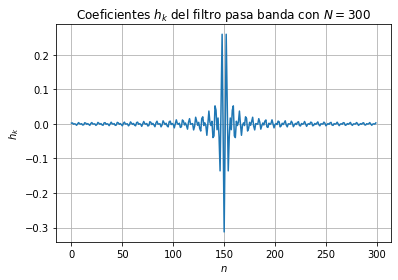

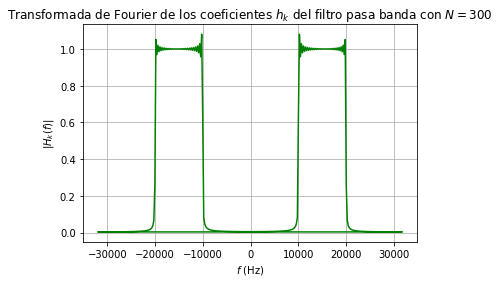

In [19]:
N = 300 # Orden del filtro

bandpass = crear_bandpass(N, Fc1, Fc2)

plt.plot(range(0,N), bandpass)
plt.grid()
plt.xlabel('$n$')
plt.ylabel('$h_k$')
plt.title("Coeficientes $h_k$ del filtro pasa banda con " + f"$N={N}$")

fourierBP = fft(bandpass)
fhk = fftfreq(len(bandpass), 1/samprate3)

plt.figure()

plt.plot(fhk, np.abs(fourierBP), color='g')
plt.grid()
plt.xlim()
plt.xlabel('$f$ (Hz)')
plt.ylabel('|$H_k(f)$|')
plt.title("Transformada de Fourier de los coeficientes $h_k$ del filtro pasa banda con " + f"$N={N}$")

Se filtra la señal de entrada con el filtro pasa banda, generando una señal $filtrada$.

Text(0.5, 1.0, 'Transformada de Fourier de $s(t)$ filtrada ($N=$300)')

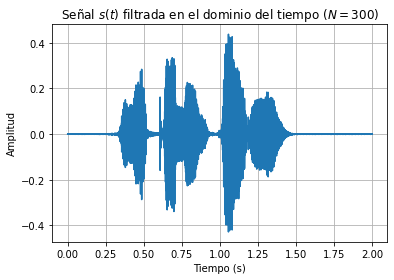

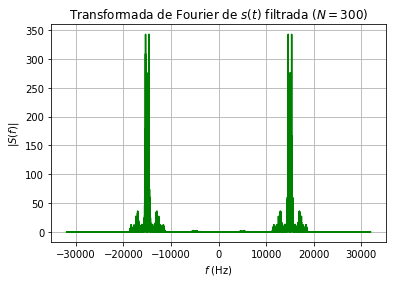

In [6]:
# Paso 3 - Implementar la ecuación de diferencias

filtrada = filtrar_señal(N, bandpass, s3)

plt.plot(t, filtrada)
plt.grid()
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title("Señal $s(t)$ filtrada en el dominio del tiempo " + f"($N=${N})")

fourierf = fft(filtrada)
f1 = fftfreq(len(filtrada), 1/samprate3)

plt.figure()

plt.plot(f1, np.abs(fourierf), color='g')
plt.grid()
plt.xlabel('$f$ (Hz)')
plt.ylabel('|$S(f)$|')
plt.title("Transformada de Fourier de $s(t)$ filtrada "  + f"($N=${N})")

Se crea un coseno de frecuencia fundamental de $15kHz$, para hacer la demodulación de la señal filtrada por el pasabanda.

In [7]:
x, coseno = generate_cos_wave(15000, samprate3, duration)

Se crea una señal $preLP$, que corresponde a la salida de la demodulación. Es decir, es el resultado de multiplicar la señal filtrada por el pasa banda con el coseno.

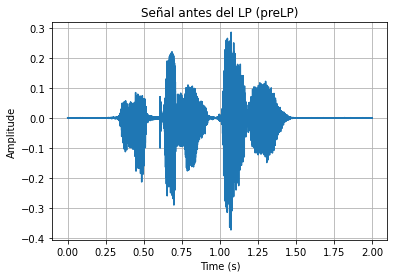

Text(0.5, 1.0, 'Transformada de Fourier de la señal antes del LP (preLP)')

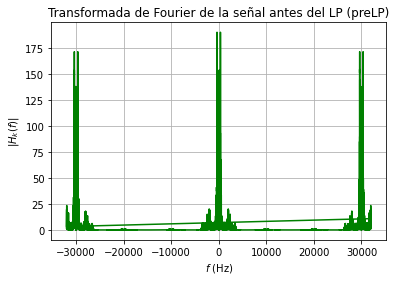

In [8]:
preLP = np.multiply(filtrada, coseno)

plt.grid()
plt.plot(x, preLP)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title("Señal antes del LP (preLP)")
plt.show()

fourierPreLP = fft(preLP)
fpreLP = fftfreq(len(preLP), 1/samprate3)

plt.figure()

plt.plot(fpreLP, np.abs(fourierPreLP), color='g')
plt.grid()
plt.xlim()
plt.xlabel('$f$ (Hz)')
plt.ylabel('|$H_k(f)$|')
plt.title("Transformada de Fourier de la señal antes del LP (preLP)")

Se crea el filtro pasabajas de la última etapa de demodulación ($LP$) con frecuencia de corte en $10kHz$ para solo tomar la parte importante de la señal $preLP$.

Text(0.5, 1.0, 'Transformada de Fourier de los coeficientes $h_k$ del filtro LP con $N=300$')

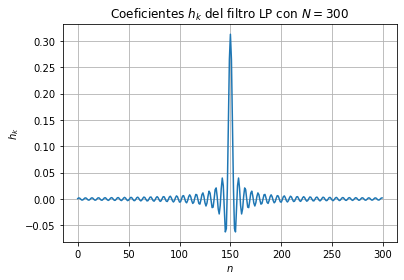

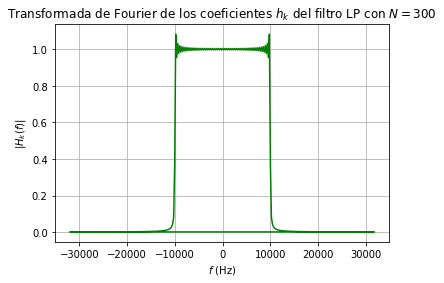

In [9]:
LP = crear_LP(N, Fc1)

plt.plot(range(0,N), LP)
plt.grid()
plt.xlabel('$n$')
plt.ylabel('$h_k$')
plt.title("Coeficientes $h_k$ del filtro LP con " + f"$N={N}$")

fourierLP = fft(LP)
fLP = fftfreq(len(LP), 1/samprate3)

plt.figure()

plt.plot(fLP, np.abs(fourierLP), color='g')
plt.grid()
plt.xlim()
plt.xlabel('$f$ (Hz)')
plt.ylabel('|$H_k(f)$|')
plt.title("Transformada de Fourier de los coeficientes $h_k$ del filtro LP con " + f"$N={N}$")

La primera señal decodificada corresponde al resultado de pasar la señal $preLP$ por el filtro pasabajas recién creado. Se realiza el correspondiente proceso de filtrado y se escucha el mensaje decodificado.

Text(0.5, 1.0, 'Transformada de Fourier de la señal decodificada')

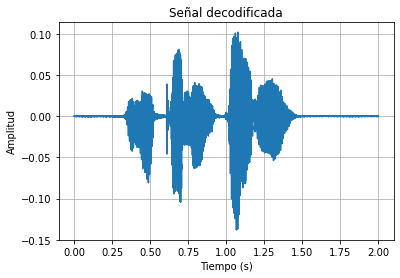

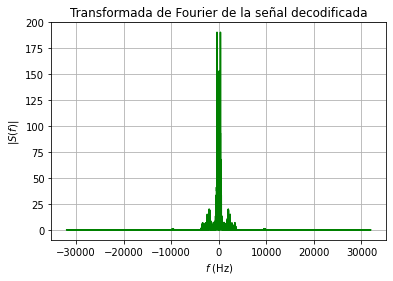

In [10]:
decodificada = filtrar_señal(N, LP, preLP)

plt.plot(t, decodificada)
plt.grid()
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title("Señal decodificada")

fourierDecod = fft(decodificada)
fDecod = fftfreq(len(decodificada), 1/samprate3)

plt.figure()

plt.plot(fDecod, np.abs(fourierDecod), color='g')
plt.grid()
plt.xlabel('$f$ (Hz)')
plt.ylabel('|$S(f)$|')
plt.title("Transformada de Fourier de la señal decodificada")

In [11]:
wavio.write("mensaje1.wav", np.asarray(decodificada), samprate3, sampwidth=2)
playsound("mensaje1.wav")

## Decodificación del segundo mensaje

Se empieza por crear un filtro pasabajas con frecuencia de corte de $10kHz$ para tomar las frecuencias de $5kHz$ de la señal original.

Text(0.5, 1.0, 'Transformada de Fourier de los coeficientes $h_k$ del filtro LP1 con $N=300$')

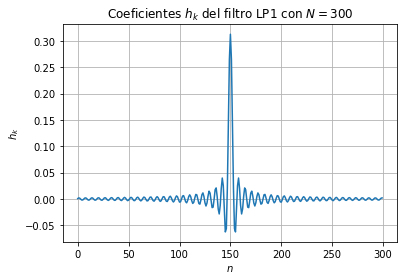

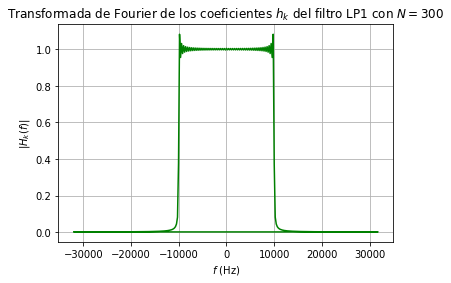

In [12]:
LP1 = crear_LP(N, Fc1)

plt.plot(range(0,N), LP1)
plt.grid()
plt.xlabel('$n$')
plt.ylabel('$h_k$')
plt.title("Coeficientes $h_k$ del filtro LP1 con " + f"$N={N}$")

fourierLP1 = fft(LP1)
fLP1 = fftfreq(len(LP1), 1/samprate3)

plt.figure()

plt.plot(fLP1, np.abs(fourierLP1), color='g')
plt.grid()
plt.xlim()
plt.xlabel('$f$ (Hz)')
plt.ylabel('|$H_k(f)$|')
plt.title("Transformada de Fourier de los coeficientes $h_k$ del filtro LP1 con " + f"$N={N}$")

Se filtra la señal original con este nuevo filtro pasa bajas.

Text(0.5, 1.0, 'Transformada de Fourier de $s(t)$ filtrada ($N=$300)')

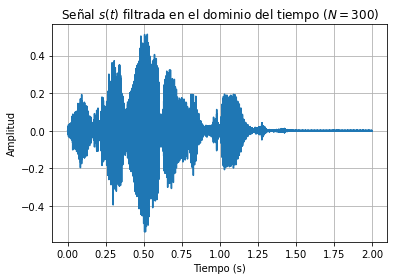

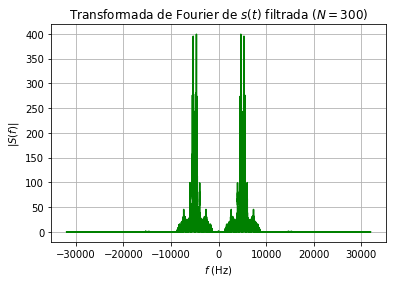

In [13]:
filtrada2 = filtrar_señal(N, LP1, s3)

plt.plot(t, filtrada2)
plt.grid()
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title("Señal $s(t)$ filtrada en el dominio del tiempo " + f"($N=${N})")

fourierf = fft(filtrada2)
f1 = fftfreq(len(filtrada2), 1/samprate3)

plt.figure()

plt.plot(f1, np.abs(fourierf), color='g')
plt.grid()
plt.xlabel('$f$ (Hz)')
plt.ylabel('|$S(f)$|')
plt.title("Transformada de Fourier de $s(t)$ filtrada "  + f"($N=${N})")

Se genera un coseno de $5kHz$ para realizar la demodulación. El resultado de la multiplicación corresponde a la señal $preLP2$.

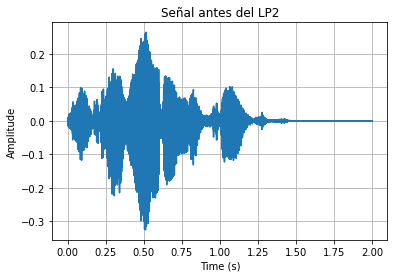

Text(0.5, 1.0, 'Transformada de Fourier de la señal antes del LP2')

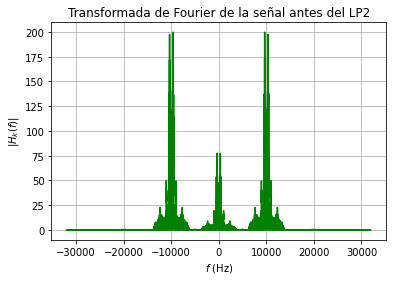

In [14]:
# Generate a 5kHz hertz cosine wave that lasts for 2 seconds
x2, coseno2 = generate_cos_wave(5000, samprate3, duration)

preLP2 = np.multiply(filtrada2, coseno2)

plt.grid()
plt.plot(x2, preLP2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title("Señal antes del LP2")
plt.show()

fourierPreLP2 = fft(preLP2)
fpreLP2 = fftfreq(len(preLP2), 1/samprate3)

plt.figure()

plt.plot(fpreLP2, np.abs(fourierPreLP2), color='g')
plt.grid()
plt.xlim()
plt.xlabel('$f$ (Hz)')
plt.ylabel('|$H_k(f)$|')
plt.title("Transformada de Fourier de la señal antes del LP2")

Se crea el filtro pasabajas de $5kHz$ correspondiente a la última etapa de la demodulación para tomar solo la parte de la señal que nos interesa y se realiza el proceso de filtrado. El resultado corresponde al segundo mensaje decodificado de la señal original.

Text(0.5, 1.0, 'Transformada de Fourier de los coeficientes $h_k$ del filtro LP5k con $N=300$')

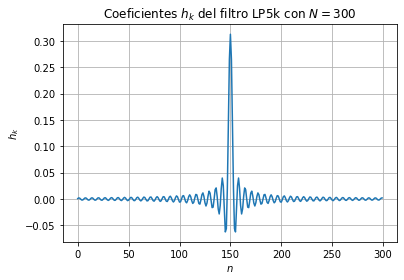

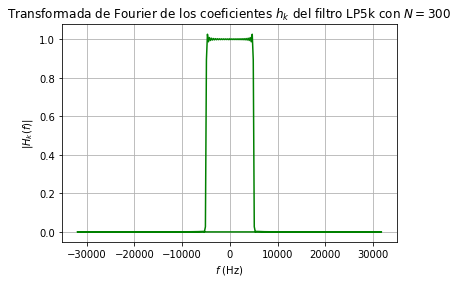

In [18]:
LP5k = crear_LP(N, Fc5)

plt.plot(range(0,N), LP1)
plt.grid()
plt.xlabel('$n$')
plt.ylabel('$h_k$')
plt.title("Coeficientes $h_k$ del filtro LP5k con " + f"$N={N}$")

fourierLP5k = fft(LP5k)
fLP5k = fftfreq(len(LP5k), 1/samprate3)

plt.figure()

plt.plot(fLP5k, np.abs(fourierLP5k), color='g')
plt.grid()
plt.xlim()
plt.xlabel('$f$ (Hz)')
plt.ylabel('|$H_k(f)$|')
plt.title("Transformada de Fourier de los coeficientes $h_k$ del filtro LP5k con " + f"$N={N}$")

Text(0.5, 1.0, 'Transformada de Fourier de la señal decodificada')

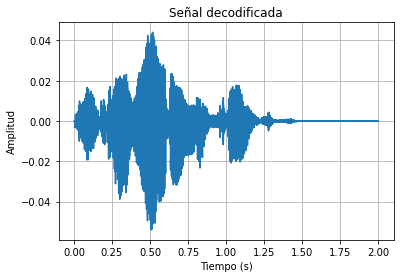

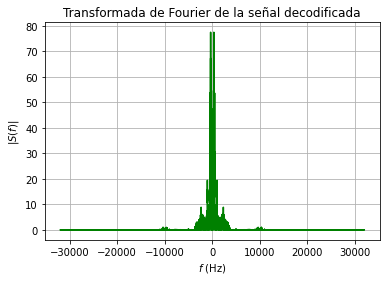

In [15]:
decodificada2 = filtrar_señal(N, LP5k, preLP2)

plt.plot(t, decodificada2)
plt.grid()
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title("Señal decodificada")

fourierDecod2 = fft(decodificada2)
fDecod2 = fftfreq(len(decodificada2), 1/samprate3)

plt.figure()

plt.plot(fDecod2, np.abs(fourierDecod2), color='g')
plt.grid()
plt.xlabel('$f$ (Hz)')
plt.ylabel('|$S(f)$|')
plt.title("Transformada de Fourier de la señal decodificada")

In [16]:
wavio.write("mensaje2.wav", np.asarray(decodificada2), samprate3, sampwidth=2)
playsound("mensaje2.wav")